In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import FunctionTransformer
import joblib
import os 


In [14]:
def drop_columns_and_remove_duplicates(df: pd.DataFrame, columns_to_drop: list) -> pd.DataFrame:
    """
    Drops specified columns and removes duplicate rows from the DataFrame.
    Args:
        df (pd.DataFrame): Input DataFrame.
        columns_to_drop (list): List of column names to drop.
    Returns
        pd.DataFrame: DataFrame with specified columns dropped and duplicates removed.
    
    """
    # make a copy of dataframe to avoid changing the original one
    df_copy = df.copy()
    # drop specified columns
    df_copy = df_copy.drop(columns=columns_to_drop, errors='ignore',axis=1, inplace=False)
    # remove duplicate rows
    df_copy = df_copy.drop_duplicates()
    return df_copy


In [2]:
from ucimlrepo import fetch_ucirepo


def load_data():
    """Load the secondary mushroom dataset.

    Returns
    -------
    X : pandas.DataFrame
        Features.
    y : pandas.Series
        Target.
    """
    # fetch dataset
    secondary_mushroom = fetch_ucirepo(id=848)

    # data (as pandas dataframes)
    X = secondary_mushroom.data.features
    y = secondary_mushroom.data.targets  # Convert to Series if single column

    return X, y


In [77]:
X , y = load_data() 
X.shape

(61069, 20)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                  random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (54962, 20), y_train shape: (54962, 1)
X_test shape: (6107, 20), y_test shape: (6107, 1)


In [79]:
y_test.head()

,class
25769,p
54695,e
24562,e
19648,p
3597,p


In [41]:
y_train.isnull().sum()

class    0
dtype: int64

In [80]:
X_train.isnull().mean() * 100

cap-diameter             0.000000
cap-shape                0.000000
cap-surface             23.157818
cap-color                0.000000
does-bruise-or-bleed     0.000000
gill-attachment         16.220298
gill-spacing            40.984680
gill-color               0.000000
stem-height              0.000000
stem-width               0.000000
stem-root               84.372839
stem-surface            62.386740
stem-color               0.000000
veil-type               94.781849
veil-color              87.895273
has-ring                 0.000000
ring-type                3.973655
spore-print-color       89.583712
habitat                  0.000000
season                   0.000000
dtype: float64

In [81]:
df_train = X_train.copy()
df_train['class'] = y_train.copy()
df_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
41732,1.58,b,h,n,f,a,NaN,n,4.51,1.40,...,t,n,NaN,NaN,f,f,NaN,h,a,p
43515,10.15,x,y,n,t,e,NaN,p,9.18,16.91,...,y,w,NaN,NaN,t,l,NaN,l,a,e
10798,2.36,b,NaN,g,f,a,NaN,g,5.24,2.12,...,s,g,NaN,NaN,f,f,NaN,d,a,p
49835,13.32,x,h,n,t,p,NaN,y,9.06,28.67,...,NaN,y,NaN,NaN,f,f,NaN,d,u,p
23893,4.65,f,NaN,p,f,x,NaN,w,5.57,7.38,...,NaN,w,NaN,NaN,f,f,NaN,d,a,p


In [82]:
n_p = df_train.isnull().mean() * 100
names = df_train.columns

In [83]:
def drop(null_data:pd.Series, percentage:float,names)->list[bool]:
    """
    Args:
        null_data : series of percentages of null values in the data
        percentage : allowed percentage in data
    output:   
        list of boolean -> tells you if this feature is with us or not (true = out)
    """
    return [names[i] for i in range(len(null_data)) if null_data[i]>percentage]

In [84]:
to_drop = drop(null_data=n_p,percentage = 2.0 ,names = names)
to_drop,len(to_drop)

C:\Users\Samy Adel\AppData\Local\Temp\ipykernel_27016\2025621804.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return [names[i] for i in range(len(null_data)) if null_data[i]>percentage]


(['cap-surface',
  'gill-attachment',
  'gill-spacing',
  'stem-root',
  'stem-surface',
  'veil-type',
  'veil-color',
  'ring-type',
  'spore-print-color'],
 9)

In [85]:
# first part in the pipeline
preprocessor = FunctionTransformer(drop_columns_and_remove_duplicates, kw_args={'columns_to_drop': to_drop})

In [86]:
df_cleaned  = preprocessor.fit_transform(df_train)
df_cleaned.shape

(54828, 12)

In [87]:
df_cleaned.head()

,cap-diameter,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-height,stem-width,stem-color,has-ring,habitat,season,class
41732,1.58,b,n,f,n,4.51,1.40,n,f,h,a,p
43515,10.15,x,n,t,p,9.18,16.91,w,t,l,a,e
10798,2.36,b,g,f,g,5.24,2.12,g,f,d,a,p
49835,13.32,x,n,t,y,9.06,28.67,y,f,d,u,p
23893,4.65,f,p,f,w,5.57,7.38,w,f,d,a,p


In [88]:
y_train.value_counts()

class
p        30499
e        24463
Name: count, dtype: int64

the data is not balanced keep that in mind 

In [89]:
# now we want to explore the data 
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54828 entries, 41732 to 5789
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          54828 non-null  float64
 1   cap-shape             54828 non-null  object 
 2   cap-color             54828 non-null  object 
 3   does-bruise-or-bleed  54828 non-null  object 
 4   gill-color            54828 non-null  object 
 5   stem-height           54828 non-null  float64
 6   stem-width            54828 non-null  float64
 7   stem-color            54828 non-null  object 
 8   has-ring              54828 non-null  object 
 9   habitat               54828 non-null  object 
 10  season                54828 non-null  object 
 11  class                 54828 non-null  object 
dtypes: float64(3), object(9)
memory usage: 5.4+ MB


to start our investigation we split the data into numrical and categorical features and start doing (Univariate, Bivariate, Multivariate) analysis on the data 

In [90]:
#X_train.isnull().sum() / len(X_train) * 100
df_cleaned.isnull().mean() * 100 

cap-diameter            0.0
cap-shape               0.0
cap-color               0.0
does-bruise-or-bleed    0.0
gill-color              0.0
stem-height             0.0
stem-width              0.0
stem-color              0.0
has-ring                0.0
habitat                 0.0
season                  0.0
class                   0.0
dtype: float64

In [91]:
y_train = df_cleaned['class']
X_train  = df_cleaned.drop(columns=['class'], axis=1)
X_train.shape, y_train.shape

((54828, 11), (54828,))

In [92]:
# numerical pipeline 
num_pipeline  = Pipeline(steps=[
    ('Anova F-test', SelectKBest(score_func=f_classif, k=2)),
    ('Scaler', StandardScaler())
])

# categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('encoding' , OneHotEncoder(drop='first', sparse_output=False)),
    ('Chi2', SelectKBest(score_func=chi2, k=30))
])

# full pipeline
full_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, X_train.select_dtypes(include=['int64', 'float64']).columns),
    ('cat', cat_pipeline, X_train.select_dtypes(include=['object', 'category']).columns),
], remainder='drop',
n_jobs=-1
)

# fit and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train,y_train) 
le =  LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
X_train_prepared.shape, y_train_encoded.shape

((54828, 32), (54828,))

In [115]:
svm_pipeline = make_pipeline(
    full_pipeline,
    PCA(n_components=20),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
)
svm_pipeline.fit(X_train, y_train_encoded)
y_pred = svm_pipeline.predict(X_train)
print(classification_report(y_train_encoded, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91     24463
           1       0.93      0.92      0.93     30365

    accuracy                           0.92     54828
   macro avg       0.92      0.92      0.92     54828
weighted avg       0.92      0.92      0.92     54828



In [126]:
knn_pipeline = make_pipeline(
    full_pipeline,
    PCA(n_components=20),
    KNeighborsClassifier(n_neighbors=5)
)
knn_pipeline.fit(X_train, y_train_encoded)
y_pred = knn_pipeline.predict(X_train)
print(classification_report(y_train_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     24463
           1       0.98      0.98      0.98     30365

    accuracy                           0.97     54828
   macro avg       0.97      0.97      0.97     54828
weighted avg       0.97      0.97      0.97     54828



In [ ]:
X_test.shape , y_test.shape

((6107, 20), (6107, 1))

In [ ]:
df_test = X_test.copy()
df_test['class'] = y_test.copy()
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
25769,4.70,x,NaN,w,f,NaN,c,g,2.33,11.63,...,NaN,y,NaN,NaN,f,f,NaN,d,a,p
54695,3.42,x,w,y,f,f,f,f,5.62,14.21,...,NaN,y,NaN,NaN,f,f,NaN,d,u,e
24562,11.42,x,e,l,f,x,c,w,7.64,19.55,...,NaN,w,NaN,NaN,f,f,NaN,d,a,e
19648,3.02,x,y,o,f,a,NaN,y,3.23,5.60,...,NaN,o,NaN,NaN,f,f,NaN,m,a,p
3597,3.58,b,y,n,f,e,c,n,4.99,3.59,...,k,w,NaN,NaN,t,e,NaN,d,a,p


In [ ]:
df_test.duplicated().sum()

np.int64(0)

In [117]:
df_test_cleaned  = drop_columns_and_remove_duplicates(df_test, to_drop)
df_test_cleaned.shape

(6106, 12)

In [118]:
y_test.head()  

25769    p
54695    e
24562    e
19648    p
3597     p
Name: class, dtype: object

In [119]:
df_test_cleaned.shape

(6106, 12)

In [120]:
y_test = df_test_cleaned['class']
X_test_cleaned = df_test_cleaned.drop(columns=['class'])
y_test_encoded = le.transform(y_test)

In [121]:
y_test_encoded.shape, X_test_cleaned.shape

((6106,), (6106, 11))

In [122]:
y_test_encoded

array([1, 0, 0, ..., 1, 0, 0], shape=(6106,))

In [123]:
#  --- IGNORE ---
svm_y_test_pred = svm_pipeline.predict(X_test_cleaned)
print(classification_report(y_test_encoded, svm_y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2718
           1       0.93      0.93      0.93      3388

    accuracy                           0.92      6106
   macro avg       0.92      0.92      0.92      6106
weighted avg       0.92      0.92      0.92      6106



In [124]:
svm_y_test_pred

array([1, 1, 0, ..., 1, 0, 0], shape=(6106,))

In [127]:
knn_y_test_pred = knn_pipeline.predict(X_test_cleaned)
print(classification_report(y_test_encoded, knn_y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2718
           1       0.96      0.97      0.97      3388

    accuracy                           0.96      6106
   macro avg       0.96      0.96      0.96      6106
weighted avg       0.96      0.96      0.96      6106



In [18]:
# split the data into categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object'])
numerical_features = X_train.select_dtypes(include=['int64', 'float64'])
categorical_features.shape, numerical_features.shape

((54828, 8), (54828, 3))

### nurmical features analysis


In [63]:
numerical_features.describe()

,cap-diameter,stem-height,stem-width
count,54828.000000,54828.000000,54828.000000
mean,6.741734,6.597107,12.184405
std,5.258447,3.368347,10.017147
min,0.380000,0.000000,0.000000
25%,3.490000,4.640000,5.260000
50%,5.880000,5.960000,10.220000
75%,8.560000,7.740000,16.600000
max,62.340000,33.920000,103.910000


<Axes: >

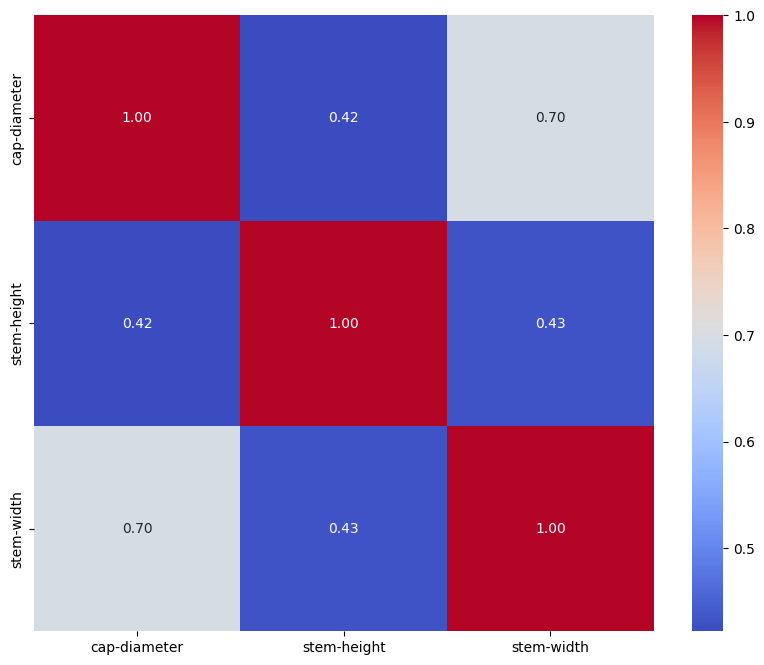

In [64]:
corr = numerical_features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f") 

<Figure size 600x600 with 0 Axes>

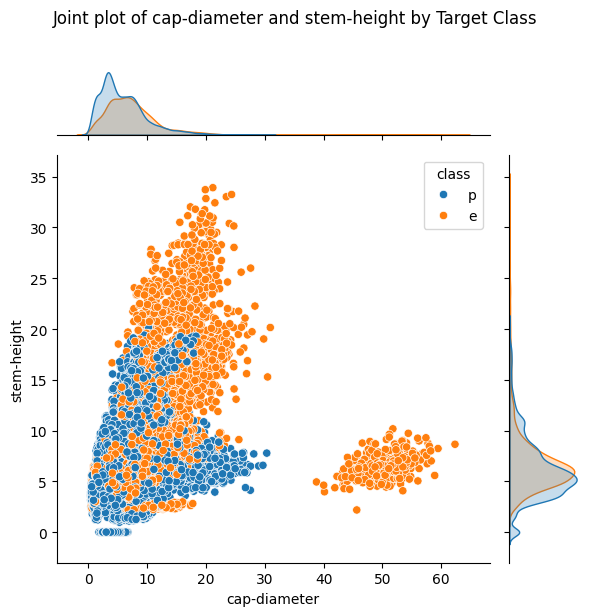

<Figure size 600x600 with 0 Axes>

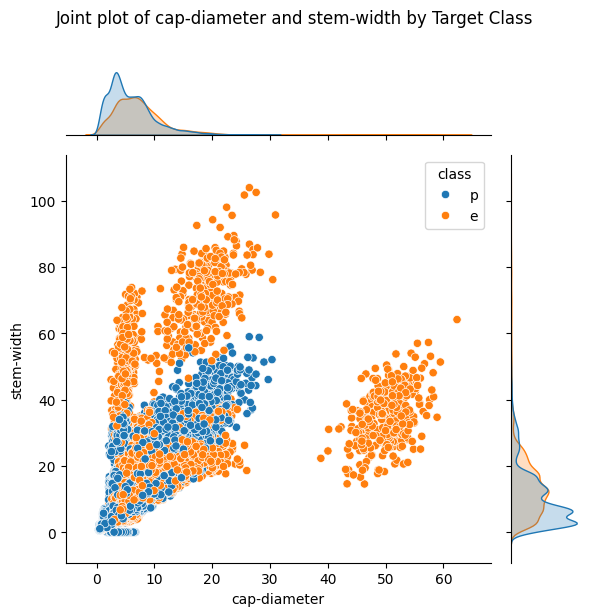

<Figure size 600x600 with 0 Axes>

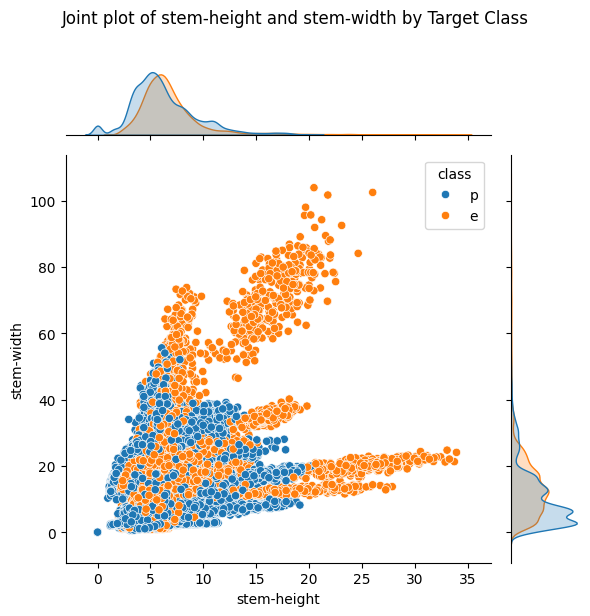

In [80]:
for i in range(len(numerical_features.columns)):
    for j in range(i+1, len(numerical_features.columns)):
        plt.figure(figsize=(6, 6))
        sns.jointplot(x=numerical_features.columns[i], y=numerical_features.columns[j], data=numerical_features, hue=y_train['class'], kind='scatter')
        plt.suptitle(f'Joint plot of {numerical_features.columns[i]} and {numerical_features.columns[j]} by Target Class', y=1.02)
        plt.tight_layout()
        plt.show()

## for the categorical features

In [65]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54828 entries, 41732 to 5789
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cap-shape             54828 non-null  object
 1   cap-color             54828 non-null  object
 2   does-bruise-or-bleed  54828 non-null  object
 3   gill-color            54828 non-null  object
 4   stem-color            54828 non-null  object
 5   has-ring              54828 non-null  object
 6   habitat               54828 non-null  object
 7   season                54828 non-null  object
dtypes: object(8)
memory usage: 3.8+ MB


In [66]:
categorical_features.isnull().sum()

cap-shape               0
cap-color               0
does-bruise-or-bleed    0
gill-color              0
stem-color              0
has-ring                0
habitat                 0
season                  0
dtype: int64

now want i want to dig into is how each categorical feature is corrleated with the target 

In [67]:
categorical_features.head()

,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,habitat,season
41732,b,n,f,n,n,f,h,a
43515,x,n,t,p,w,t,l,a
10798,b,g,f,g,g,f,d,a
49835,x,n,t,y,y,f,d,u
23893,f,p,f,w,w,f,d,a


In [70]:
y_train.head()

41732    p
43515    e
10798    p
49835    p
23893    p
Name: class, dtype: object

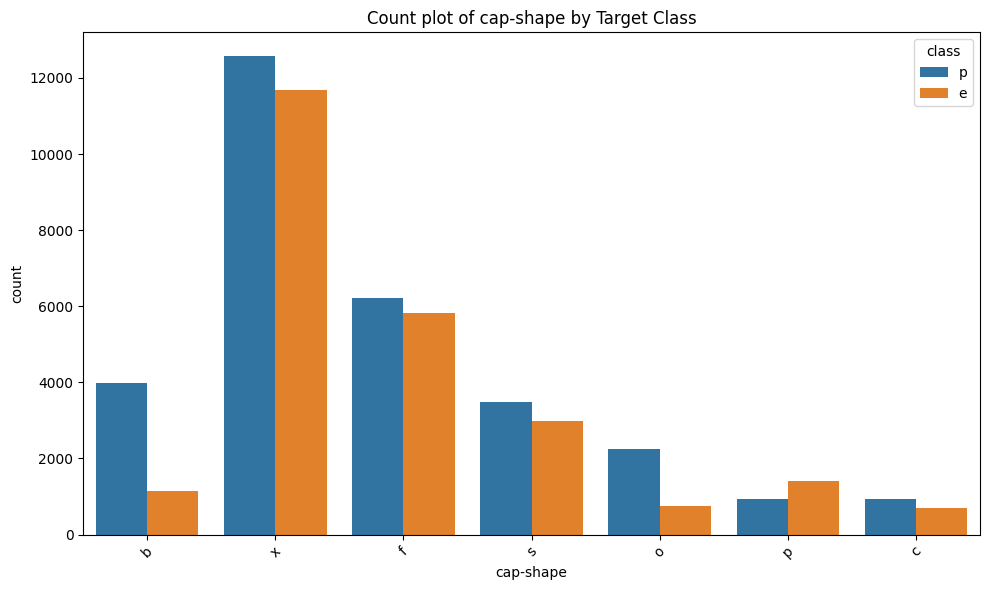

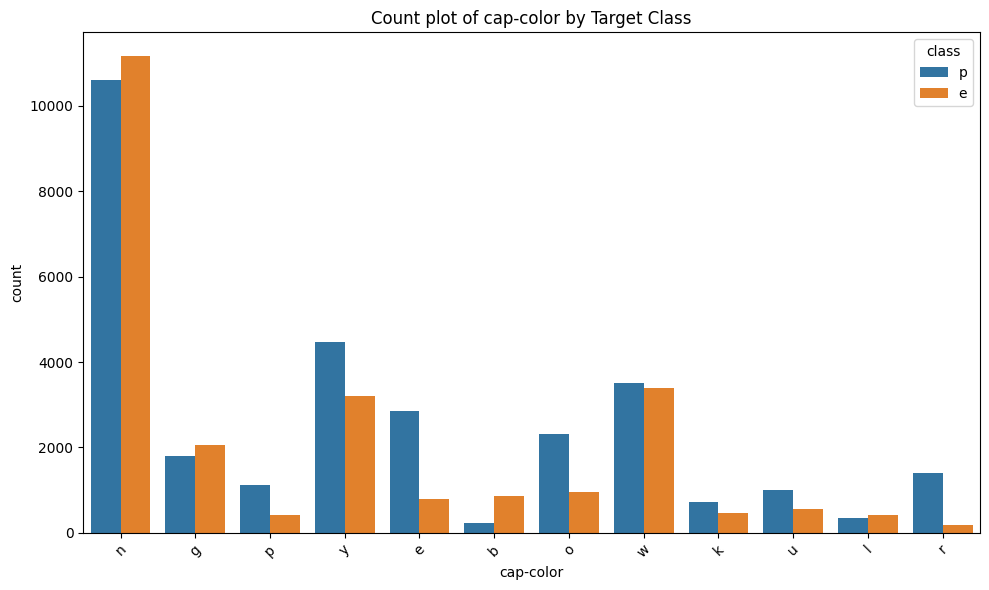

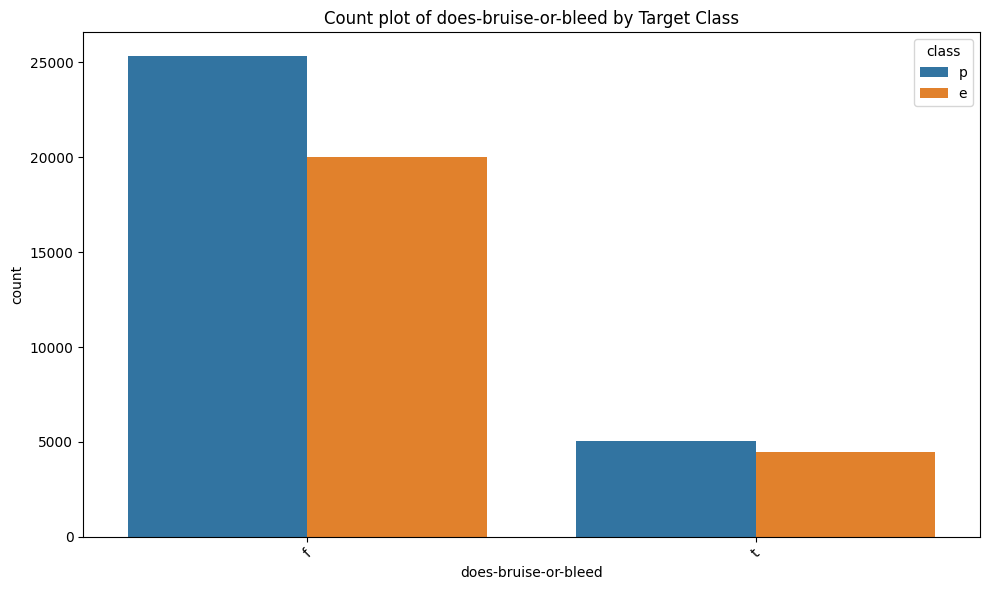

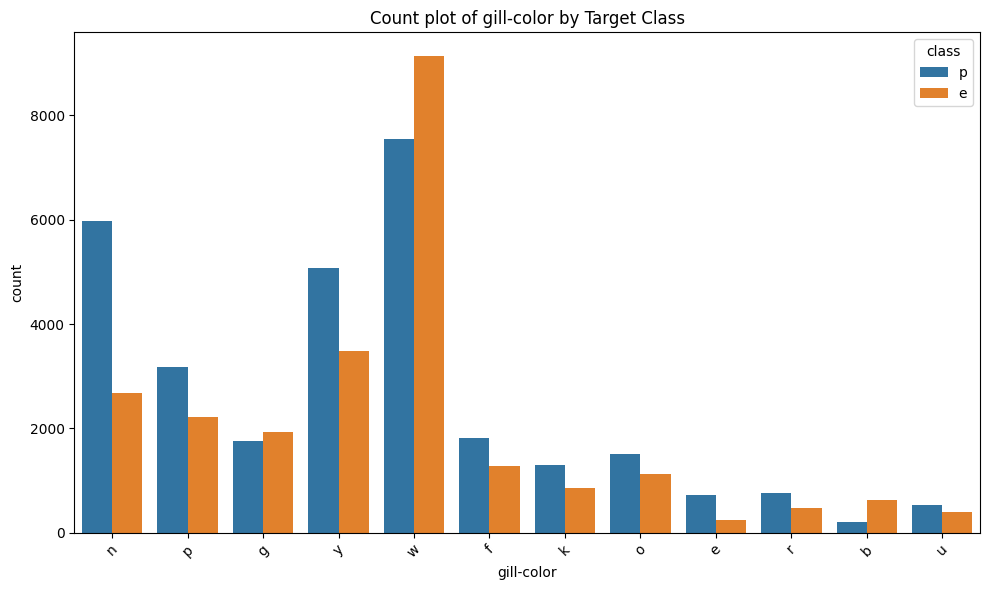

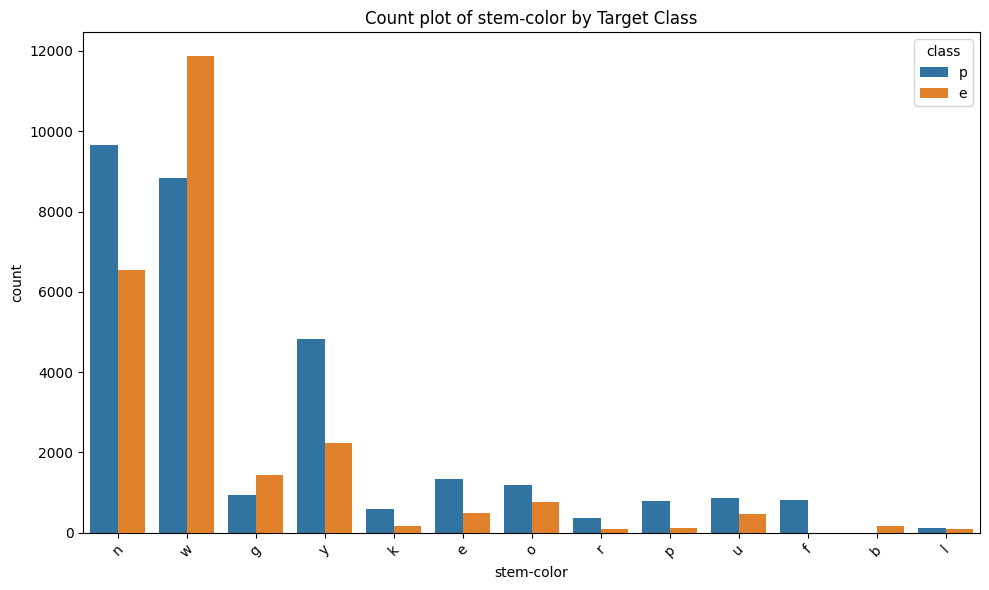

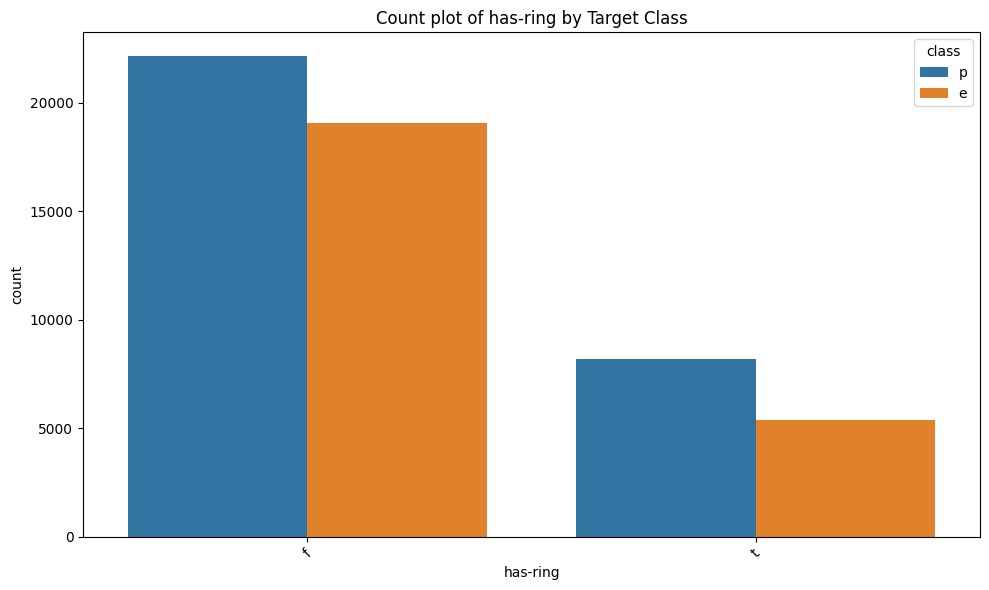

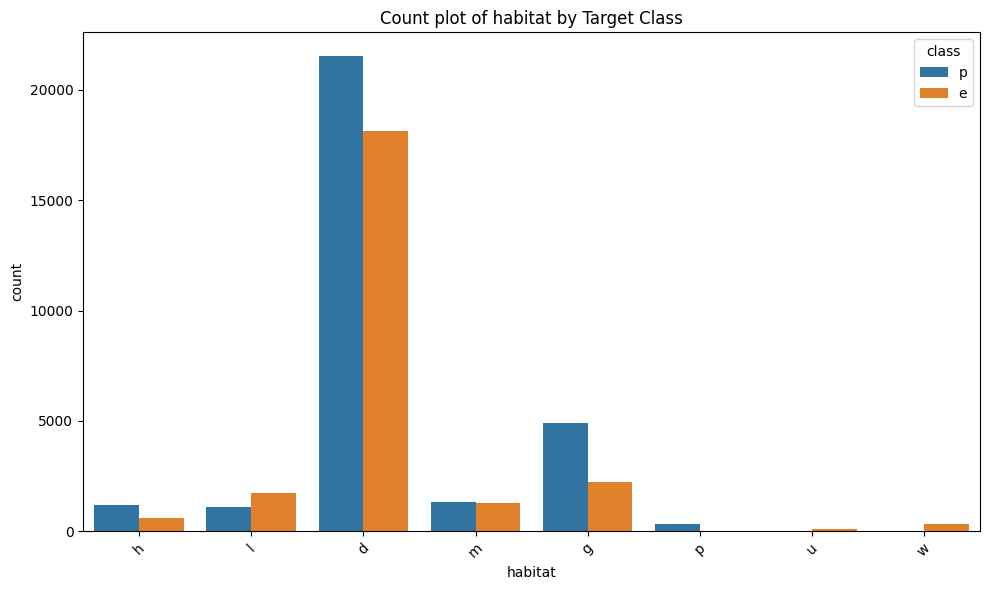

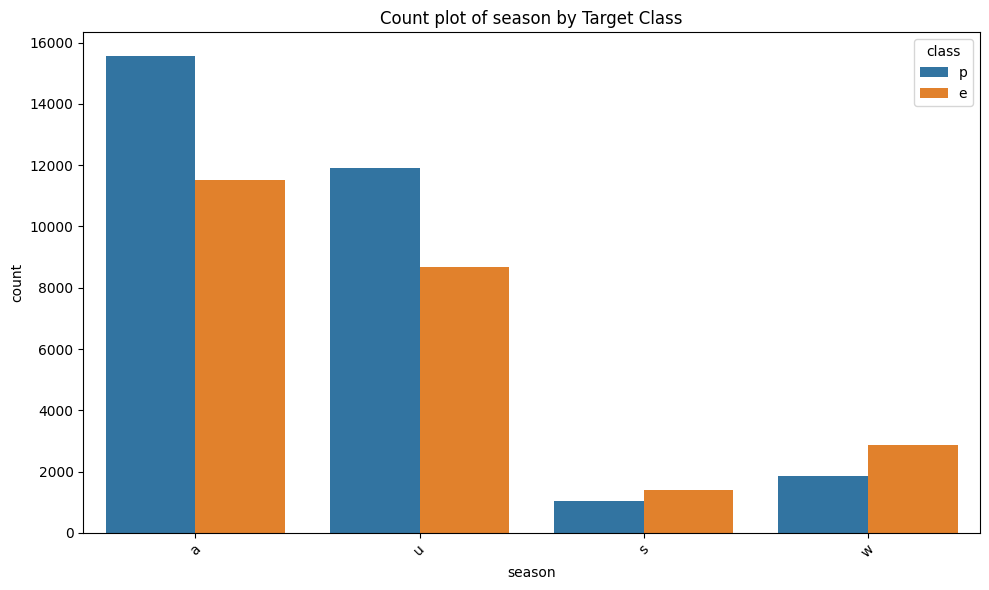

In [72]:
# bar plots for categorical features with target class as hue
for col in categorical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=categorical_features, x=col, hue=y_train)
    plt.title(f'Count plot of {col} by Target Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
# apply anova f_test
selector = SelectKBest(score_func=f_classif, k=2)
selected_numerical = selector.fit_transform(numerical_features, y_train)
selected_numerical.shape

(54828, 2)

In [30]:
# scaling the selected numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(selected_numerical)

In [20]:
# applay encoding to categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(categorical_features)
encoded_categorical.shape

(54828, 52)

In [39]:
# using chi2 to select top 10 features
selector_chi2 = SelectKBest(score_func=chi2, k=30)
X_selected_categorical = selector_chi2.fit_transform(encoded_categorical, y_train)
X_selected_categorical.shape

(54828, 30)

In [40]:
# concatenate selected numerical and categorical features
X_final = np.hstack((selected_numerical, X_selected_categorical))
X_final.shape

(54828, 32)

In [42]:
# apply pca to reduce dimensionality
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_final)
X_pca.shape

(54828, 20)

In [43]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train.shape

(54828,)

In [44]:
# modeling
support_vector_model = SVC()
support_vector_model.fit(X_pca, y_train)
y_pred = support_vector_model.predict(X_pca)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     24463
           1       0.81      0.83      0.82     30365

    accuracy                           0.80     54828
   macro avg       0.79      0.79      0.79     54828
weighted avg       0.80      0.80      0.80     54828



In [45]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_pca, y_train)
y_pred_log = log_model.predict(X_pca)
print(classification_report(y_train, y_pred_log))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62     24463
           1       0.70      0.75      0.72     30365

    accuracy                           0.68     54828
   macro avg       0.68      0.67      0.67     54828
weighted avg       0.68      0.68      0.68     54828



In [46]:
random_forest =  RandomForestClassifier()
random_forest.fit(X_pca, y_train)
y_pred_rf = random_forest.predict(X_pca)
print(classification_report(y_train, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24463
           1       1.00      1.00      1.00     30365

    accuracy                           1.00     54828
   macro avg       1.00      1.00      1.00     54828
weighted avg       1.00      1.00      1.00     54828



In [47]:
knn = KNeighborsClassifier()
knn.fit(X_pca, y_train)
y_pred_knn = knn.predict(X_pca)
print(classification_report(y_train, y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     24463
           1       0.97      0.97      0.97     30365

    accuracy                           0.97     54828
   macro avg       0.97      0.97      0.97     54828
weighted avg       0.97      0.97      0.97     54828



In [48]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_pca, y_train)
y_pred_tree = tree_model.predict(X_pca)
print(classification_report(y_train, y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24463
           1       1.00      1.00      1.00     30365

    accuracy                           1.00     54828
   macro avg       1.00      1.00      1.00     54828
weighted avg       1.00      1.00      1.00     54828



fine tuning the model 